In [2]:
#数据处理部分之前的代码，保持不变
import os
import random
import paddle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import gzip
import json

# 定义数据集读取器
def load_data(mode='train'):

    # 加载数据
    datafile = './data/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')

    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28

    if mode == 'train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode == 'valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode == 'eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")

    #校验数据
    imgs_length = len(imgs)
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    # 定义数据集每个数据的序号， 根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的batchsize
    BATCHSIZE = 100
    
    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        
        for i in index_list:
           
            # img = np.array(imgs[i]).astype('float32')
            # label = np.array(labels[i]).astype('float32')
            
            # 在使用卷积神经网络结构时，uncomment 下面两行代码
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('float32')
            
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

In [ ]:
def sigmoid(x):
    # 直接返回sigmoid函数
    return 1. / (1. + np.exp(-x))
 
# param:起点，终点，间距
x = np.arange(-8, 8, 0.2)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

In [6]:
import paddle.nn.functional as F
from paddle.nn import Linear

# 定义多层全连接神经网络
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 定义两层全连接隐含层，输出维度是10，当前设定隐含节点数为10，可根据任务调整
        self.fc1 = Linear(in_features=784, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=128)
        # 定义一层全连接输出层，输出维度是1
        self.fc3 = Linear(in_features=128, out_features=1)
    
    # 定义网络的前向计算，隐含层激活函数为sigmoid，输出层不使用激活函数
    def forward(self, inputs):
        # inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.sigmoid(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.sigmoid(outputs2)
        outputs_final = self.fc3(outputs2)
        return outputs_final

In [3]:
# 定义 SimpleNet 网络结构
import paddle
from paddle.nn import Conv2D, MaxPool2D, Linear
import paddle.nn.functional as F
# 多层卷积神经网络实现
class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是1
         self.fc = Linear(in_features=980, out_features=1)
         
    # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
    # 卷积层激活函数使用Relu，全连接层不使用激活函数
     def forward(self, inputs):
         x = self.conv1(inputs)
         x = F.relu(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.relu(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], -1])
         x = self.fc(x)
         return x

In [4]:
#网络结构部分之后的代码，保持不变
def train(model):
    model.train()
    #调用加载数据的函数，获得MNIST训练数据集
    train_loader = load_data('train')
    # 使用SGD优化器，learning_rate设置为0.01
    opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
    # 训练5轮
    EPOCH_NUM = 10
    # MNIST图像高和宽
    IMG_ROWS, IMG_COLS = 28, 28
    loss_list = []
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)

            #每训练200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, loss))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    return loss_list


model = MNIST()
loss_list = train(model)



loading mnist dataset from ./data/mnist.json.gz ......
mnist dataset load done
epoch: 0, batch: 0, loss is: 18.310457229614258
epoch: 0, batch: 200, loss is: 8.731026649475098
epoch: 0, batch: 400, loss is: 8.745173454284668
epoch: 1, batch: 0, loss is: 8.978095054626465
epoch: 1, batch: 200, loss is: 8.0036039352417
epoch: 1, batch: 400, loss is: 8.557645797729492
epoch: 2, batch: 0, loss is: 7.554311752319336
epoch: 2, batch: 200, loss is: 8.11535358428955
epoch: 2, batch: 400, loss is: 9.873379707336426
epoch: 3, batch: 0, loss is: 8.929512977600098
epoch: 3, batch: 200, loss is: 7.692450046539307
epoch: 3, batch: 400, loss is: 7.964614391326904
epoch: 4, batch: 0, loss is: 9.171926498413086
epoch: 4, batch: 200, loss is: 9.951409339904785
epoch: 4, batch: 400, loss is: 7.964714050292969
epoch: 5, batch: 0, loss is: 8.404346466064453
epoch: 5, batch: 200, loss is: 10.029065132141113
epoch: 5, batch: 400, loss is: 9.07127571105957
epoch: 6, batch: 0, loss is: 8.990304946899414
epoch:

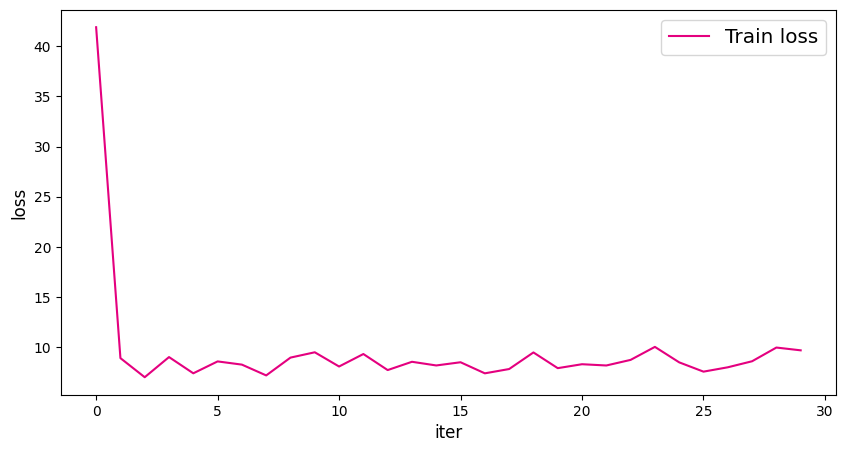

In [10]:
def plot(loss_list):
    plt.figure(figsize=(10,5))
    
    iter = [i for i in range(len(loss_list))]
    # 绘制训练损失变化曲线
    plt.plot(iter, loss_list, color='#e4007f', label="Train loss")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("iter", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

plot(loss_list)

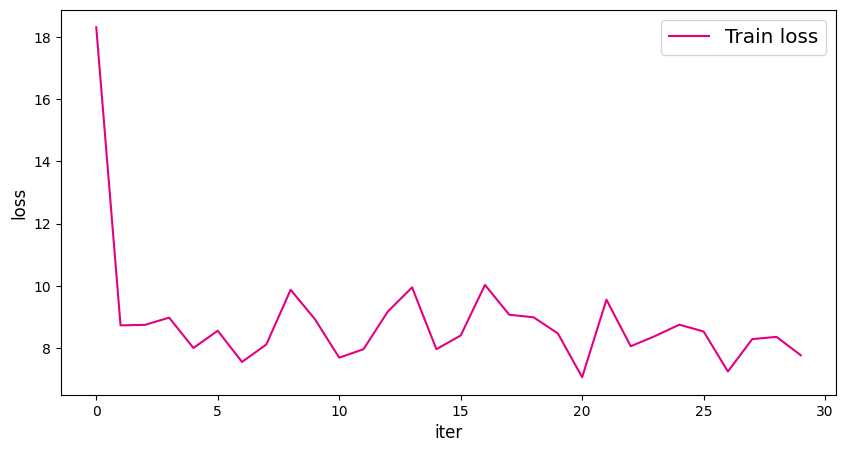

In [5]:
def plot(loss_list):
    plt.figure(figsize=(10,5))
    
    iter = [i for i in range(len(loss_list))]
    # 绘制训练损失变化曲线
    plt.plot(iter, loss_list, color='#e4007f', label="Train loss")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("iter", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

plot(loss_list)